In [1]:
import os
from datetime import datetime
import pandas as pd
import torch
import joblib
import numpy as np
from functools import lru_cache

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# For NLP
import spacy
from nltk.tokenize import TweetTokenizer

import matplotlib.pyplot as plt

In [2]:
import vae

In [3]:
AQI_PATH = "../data/aqi_data/daily_aqi_by_county_2018.csv"
TWEET_PATH = "../data/san_francisco/"

In [8]:
class Tweets:
    """Tweets class. This class handles the data and preprocesses
    so that the data can be loaded easily into whatever format
    is needed.
    """

    def __init__(
        self,
        path,
        agg_count=1000,
        sample_rate=5,
        verbose=False,
        min_df=100,
        max_df=0.1,
        test_size=0.2,
        random_state=42,
    ):
        """
        Input:
            path: directory of twitter files, unprocessed.

            agg_count: the number of tweets to aggregate by.

            sample_rate: the number of total samples that we want
            to get for each day.

            verbose: whether to print out steps of loading the data.

            min_df: passed to the count_vec. This determines the amount
                of tweets that the word must appear in to be included.

            max_df: pass to the count_vec. This indicates the max
                number of tweets that the word can occur in.

            test_size: The percentage of tweets that are held out for
                the test set.

        This class should build a count vector from the tweets themselves,
        then store the tweets in an array that can be sampled from.

        """
        self.path = path
        self.test_size = test_size
        self.random_state = random_state

        # Load in each of the CSVs.
        print("Loading in the data...")
        tweets = self._load_data()

        # Remove values without date or tweet
        tweets = tweets.dropna()
        # Perform some preprocessing as an intermediate step
        # This is a very expensive line of code (takes a long time
        # and I am going to cache the results to use between runs.
        if cached(path, "lemmatized.joblib"):
            print(
                "Cached file was found...loading lemmatized", "tweets from the cache."
            )
            tweets["clean_tweets"] = load_cached(path, "lemmatized.joblib")
        else:
            print("No cache found. Loading now")
            tweets["clean_tweets"] = self._preprocess(tweets)

        tweets["date"] = [
            datetime.strptime(d, "%Y-%m-%d %H:%M:%S").date()
            for d in tweets["created_at"]
        ]

        # Create the count vector to process the tweets
        print("Creating the count vector")
        self.count_vec = CountVectorizer(
            stop_words="english", min_df=min_df, max_df=max_df
        )
        if test_size > 0:
            self.x, self.x_test = train_test_split(
                tweets, test_size=test_size, random_state=random_state,
				stratify=tweets['date']
            )
        else:
            self.x = tweets

        # Create the count vectors
        x_cv = self.count_vec.fit_transform(self.x["clean_tweets"])
        # Remove unnecessary information and insert the count vector
        # into the x array
        self.x = np.array(list(zip(self.x["date"], x_cv)))

        # Save the cached count vector for future comparison
        if not cached(path, "lemmatized.joblib"):
            save_to_cache(self.path, self.count_vec, "count_vec.joblib")

        if test_size > 0:
            x_test_cv = self.count_vec.transform(self.x_test["clean_tweets"])
            self.x_test = np.array(list(zip(self.x_test["date"], x_test_cv)))

        self.agg_count = agg_count
        self.sample_rate = sample_rate
        self.data = None
        self.vocab_size = len(self.count_vec.get_feature_names_out())

    def _load_data(self):
        """
        This function reads the files from the path
        and returns a concatenated version of the data.
        """
        data_frame = []
        # Load the data
        files = os.listdir(self.path)
        # If there is a cached file, then remove from
        # the list
        if "cached" in files:
            files.pop(files.index("cached"))

        for file in files:
            data_frame.append(pd.read_csv(self.path + file))

        return pd.concat(data_frame)

    def _preprocess(self, tweets):
        """
        This function is used to handle lemmatizing the data
        prior to its use.
        """
        tweet_tokenizer = TweetTokenizer()
        nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        lemmatized = []

        for tweet in tweets["text"]:
            clean_tweet = [
                w for w in tweet_tokenizer.tokenize(tweet.lower()) if w.isalpha()
            ]
            doc = nlp(" ".join(clean_tweet))
            lemmatized.append(" ".join([token.lemma_ for token in doc]))

        # Save this to the cached folder
        # Try to save the file to the cached folder.
        # If it doesn't exist...create the cache.
        try:
            joblib.dump(lemmatized, self.path + "cached/lemmatized.joblib")
        except FileNotFoundError:
            os.mkdir(self.path + "/cached/")
            joblib.dump(lemmatized, self.path + "cached/lemmatized.joblib")
        return lemmatized

    def load(self, test=False):
        """ This function handles loading the data from the count vector data."""
        if test:
            return TweetDataset(
                self.x_test, agg_count=self.agg_count, sample_rate=self.sample_rate
            )

        return TweetDataset(self.x, sample_rate=self.sample_rate)

In [7]:
def cached(path, doc_type):
    """
    This function looks for the path in the list of cached
    objects and returns true if the line exists."""
    files = os.listdir(path)
    if "cached" in files:
        cached_files = os.listdir(path + "cached/")
        if doc_type in cached_files:
            return True
    return False


def load_cached(path, doc_type):
    """This function loads cached data, assuming
        it exists. This data is return as it was
        saved in the file."""
    return joblib.load(path + "cached/" + doc_type)


def save_to_cache(path, doc, file_name):
    """This saves a document to the a cache"""
    joblib.dump(doc, path + "cached/" + file_name)
    
def load_aqi():
    """
    This function returns a dictionary containing AQI with the 
    date object as the keys.
    """
    df = pd.read_csv(AQI_PATH)

    df = df[
        (df["State Name"] == "California") & (df["county Name"] == "San Francisco")
    ][["Date", "AQI"]]

    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").apply(datetime.date)

    df["AQI"] = np.log10(df["AQI"])

    return df.set_index("Date").to_dict().get("AQI")

In [12]:
class TweetDataset(Dataset):
    """This class converts the pandas dataframe into a tensor
        that will be loaded into the VAE"""

    def __init__(self, df, agg_count=1000, sample_rate=5, random_state=42):
        """
            Inputs:
                df - the dataframe object with the "count_vec" column and the date column.
                acc_count - the number of tweets to aggregate by
                sample_rate - the number of times to sample each day
        """
        # Define the objects used in the two functions below
        self.dates = list(set(df[:, 0]))
        self.agg_count = agg_count
        self.sample_rate = sample_rate
        self.generator = np.random.default_rng(seed=random_state)
        self.df = df

        # Added to support looking up aqi
        self.aqi = load_aqi()

    def __len__(self):
        """Return the length of the dataset"""
        return len(self.dates) * self.sample_rate

    @lru_cache(maxsize=None)  # Save results of this function for quicker access
    def __getitem__(self, idx):
        """
        This function selects the date at the index
        provided. If the index is greater than the length
        of the array (i.e., we are sampling multiple examples
        from a date), then wraparound and keep sampling.
        """
        # Select the date
        date = self.dates[idx % len(self.dates)]
        # Randomly sample from this date.
        #  1. Only look at count_vecs on this date.
        #  2. Sample agg_count number of tweets, sum the count vectors,
        #     and return

        count_vecs = self.df[np.where(self.df[:, 0] == date)][:, 1]

        # Sample using the generator
        sample = self.generator.choice(count_vecs, self.agg_count, replace=True)

        # Load the aqi to return
        # Return the numpy array, summed along its axis.
        return (
            torch.from_numpy(sample.sum().toarray()).float().requires_grad_(False),
            torch.tensor(self.aqi.get(date)),
        )

In [9]:
tweets = Tweets(TWEET_PATH, max_df=0.005, agg_count=1000, sample_rate=40)

Loading in the data...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.


Cached file was found...loading lemmatized tweets from the cache.
Creating the count vector


In [10]:
joblib.dump(
    tweets,
    TWEET_PATH+"cached/tweets_maxdf005_agg1000_sample40.joblib"
)

['../data/san_francisco/cached/tweets_maxdf005_agg1000_sample40.joblib']

In [3]:
# You can more quickly reload data here.
# tweets = joblib.load(TWEET_PATH+"cached/tweets_maxdf005_agg1000_sample40.joblib")

In [13]:
x_train = tweets.load()

In [14]:
x_test = tweets.load(test=True)

In [15]:
train_loader = DataLoader(x_train, batch_size=128)
test_loader = DataLoader(x_test, batch_size=128)

In [46]:
class VAE(nn.Module):
    """
    Should rename -- PFA for Poisson Factor Analysis
    """

    def __init__(self, vocab, num_components=20, prior_mean=0, prior_logvar=0):
        """
        Inputs
        --------
        vocab<int>: the size of the vocabulary

        This model only has the variational layer, then the output
        to the reconstruction. At this point, there are no hidden layers.
        """
        super().__init__()
        self.num_components = num_components

        self.prior_mean = torch.tensor(prior_mean)
        self.prior_logvar = torch.tensor(prior_logvar)

        self.enc_logvar = nn.Linear(vocab, num_components, bias=False)
        self.enc_mu = nn.Linear(vocab, num_components, bias=False)
        self.W_tilde = torch.rand(num_components, vocab, requires_grad=True)
        self.pois_nll = nn.PoissonNLLLoss(log_input=False)
        self.softplus = nn.Softplus()

        self.beta = nn.Linear(num_components, 1, bias=True)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu = self.enc_mu(x)
        logvar = self.enc_logvar(x)

        s_tilde = self.reparameterize(mu, logvar)
        
        # Change from s_tilde to mu to see if we can just
        # create a simple model to predict y_hat
        s = self.softplus(mu)
        W = self.softplus(self.W_tilde)

        # Predict y using the first node from s
        y_hat = self.beta(s)

        return s, W, mu, logvar, y_hat

    def get_topic_dist(self, x):
        """
        When it comes to looking at the norm, we want to calculate the
        probability that a certain sample belongs to each topic.
        """
        s, _ = self.encode(x)
        W = self.parameters()  # TODO - figure out which parameters to add.
        norm = torch.norm(s @ W, p=1)  # Return the L1 norm
        # TODO -- add in the multinomial distribution.

        # TODO - need to calculate elementwise product.
        return s @ W / norm

    def _kl_divergence(self, mean, logvar):
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # BUT...
        # Code extended to handle a more informative prior
        # Referencing this derivation found here:
        # https://stanford.edu/~jduchi/projects/general_notes.pdf
        # Assume diagonal matrices for variance
        KLD = -0.5 * torch.sum(
            1
            + logvar
            - self.prior_logvar
            - (mean - self.prior_mean) ** 2 / self.prior_logvar.exp()
            - logvar.exp() / self.prior_logvar.exp()
        )

        return KLD

    def loss_function(self, recon_x, x, mu, logvar, y, y_hat):
        KLD = self._kl_divergence(mu, logvar)
        PNLL = self.pois_nll(recon_x, x)
        # This will disproportionately weight higher values of y
        MSE = (y - y_hat).pow(2).mean()
        return PNLL, MSE, KLD

    @torch.no_grad()
    def reconstruct(self, X):
        s, W, mu, logvar = self.forward(X)

        return s @ W

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [51]:
model = VAE(tweets.vocab_size, num_components=1000, prior_mean=1, prior_logvar=0)
model.to(device)

EPOCHS = 40
print_rate = 10
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [42]:
tweets.vocab_size

7252

In [19]:
loss_results = {
        "train": {"pnll": [], "mse": [], "kld": [], "total": []},
        "val": {"pnll": [], "mse": [], "kld": [], "total": []},
    }

In [54]:
for epoch in range(EPOCHS):
    epoch_train_loss = 0
    epoch_test_loss = 0
    # Run method on training
    model.train()
    avg_pnll = 0
    avg_mse = 0
    avg_kld = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        # Add training data to GPU
        data = data.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        s, W, mu, logvar, y_hat = model(data)
        s = s.to(device)
        W = W.to(device)
        y_hat = y_hat.to(device)
        recon_batch = s @ W  # Calculate the reconstructed matrix
        recon_batch = recon_batch.to(device)
        mu = mu.to(device)
        logvar = logvar.to(device)
        PNLL, MSE, KLD = model.loss_function(
            recon_batch, data, mu, logvar, y, y_hat
        )

        loss = torch.mean(MSE )#+ 0.00001*PNLL + 0.000001*KLD)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            avg_pnll += torch.mean(PNLL).item()
            avg_mse += torch.mean(MSE).item()
            avg_kld += torch.mean(KLD).item()
        epoch_train_loss += loss.item()

        if batch_idx % print_rate == 0:
            print(
                "Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item()
                )
            )
    print(
        "===> Epoch: {} Average Loss: {:.4f}".format(
            epoch, epoch_train_loss / len(train_loader.dataset)
            # The above should be changed to divide by batch_idx
        )
    )
    print("PNLL: ", avg_pnll / batch_idx)
    print("MSE: ", avg_mse / batch_idx)
    print("KLD: ", avg_kld / batch_idx)

Train epoch: 0 [0/9800 (0%)]	Loss: 0.049829
Train epoch: 0 [1280/9800 (13%)]	Loss: 0.048771
Train epoch: 0 [2560/9800 (26%)]	Loss: 0.044422
Train epoch: 0 [3840/9800 (39%)]	Loss: 0.047495
Train epoch: 0 [5120/9800 (52%)]	Loss: 0.040175
Train epoch: 0 [6400/9800 (65%)]	Loss: 0.042258
Train epoch: 0 [7680/9800 (78%)]	Loss: 0.046901
Train epoch: 0 [8960/9800 (91%)]	Loss: 0.043776
===> Epoch: 0 Average Loss: 0.0004
PNLL:  8.941083908081055
MSE:  0.046465479278642884
KLD:  2469249408.0
Train epoch: 1 [0/9800 (0%)]	Loss: 0.049516
Train epoch: 1 [1280/9800 (13%)]	Loss: 0.048585
Train epoch: 1 [2560/9800 (26%)]	Loss: 0.044437
Train epoch: 1 [3840/9800 (39%)]	Loss: 0.047388
Train epoch: 1 [5120/9800 (52%)]	Loss: 0.040020
Train epoch: 1 [6400/9800 (65%)]	Loss: 0.042138
Train epoch: 1 [7680/9800 (78%)]	Loss: 0.046915
Train epoch: 1 [8960/9800 (91%)]	Loss: 0.043821
===> Epoch: 1 Average Loss: 0.0004
PNLL:  8.941083908081055
MSE:  0.0463711512520125
KLD:  2469249408.0
Train epoch: 2 [0/9800 (0%)]	L

===> Epoch: 16 Average Loss: 0.0004
PNLL:  8.941083908081055
MSE:  0.046234191787478174
KLD:  2469249408.0
Train epoch: 17 [0/9800 (0%)]	Loss: 0.048681
Train epoch: 17 [1280/9800 (13%)]	Loss: 0.048169
Train epoch: 17 [2560/9800 (26%)]	Loss: 0.044680
Train epoch: 17 [3840/9800 (39%)]	Loss: 0.047216
Train epoch: 17 [5120/9800 (52%)]	Loss: 0.039677
Train epoch: 17 [6400/9800 (65%)]	Loss: 0.041904
Train epoch: 17 [7680/9800 (78%)]	Loss: 0.047106
Train epoch: 17 [8960/9800 (91%)]	Loss: 0.044105
===> Epoch: 17 Average Loss: 0.0004
PNLL:  8.941083908081055
MSE:  0.04623418997385
KLD:  2469249408.0
Train epoch: 18 [0/9800 (0%)]	Loss: 0.048680
Train epoch: 18 [1280/9800 (13%)]	Loss: 0.048169
Train epoch: 18 [2560/9800 (26%)]	Loss: 0.044681
Train epoch: 18 [3840/9800 (39%)]	Loss: 0.047216
Train epoch: 18 [5120/9800 (52%)]	Loss: 0.039677
Train epoch: 18 [6400/9800 (65%)]	Loss: 0.041904
Train epoch: 18 [7680/9800 (78%)]	Loss: 0.047107
Train epoch: 18 [8960/9800 (91%)]	Loss: 0.044105
===> Epoch: 18

Train epoch: 33 [5120/9800 (52%)]	Loss: 0.039677
Train epoch: 33 [6400/9800 (65%)]	Loss: 0.041904
Train epoch: 33 [7680/9800 (78%)]	Loss: 0.047108
Train epoch: 33 [8960/9800 (91%)]	Loss: 0.044107
===> Epoch: 33 Average Loss: 0.0004
PNLL:  8.941083908081055
MSE:  0.046234278890647386
KLD:  2469249408.0
Train epoch: 34 [0/9800 (0%)]	Loss: 0.048678
Train epoch: 34 [1280/9800 (13%)]	Loss: 0.048169
Train epoch: 34 [2560/9800 (26%)]	Loss: 0.044681
Train epoch: 34 [3840/9800 (39%)]	Loss: 0.047216
Train epoch: 34 [5120/9800 (52%)]	Loss: 0.039677
Train epoch: 34 [6400/9800 (65%)]	Loss: 0.041904
Train epoch: 34 [7680/9800 (78%)]	Loss: 0.047108
Train epoch: 34 [8960/9800 (91%)]	Loss: 0.044107
===> Epoch: 34 Average Loss: 0.0004
PNLL:  8.941083908081055
MSE:  0.04623428741960149
KLD:  2469249408.0
Train epoch: 35 [0/9800 (0%)]	Loss: 0.048678
Train epoch: 35 [1280/9800 (13%)]	Loss: 0.048169
Train epoch: 35 [2560/9800 (26%)]	Loss: 0.044681
Train epoch: 35 [3840/9800 (39%)]	Loss: 0.047216
Train epoch

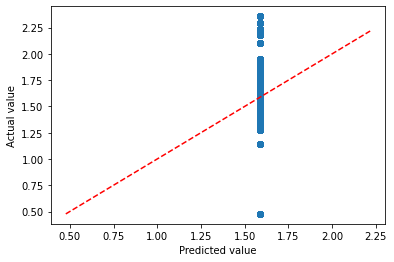

In [55]:
y_vals = []
y_preds = []
for x, y in train_loader:
    x = x.to(device)
    y_vals.append(y)
    s, W, mu, logvar, y_hat = model(x)
    y_preds.append(y_hat)

y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y), max(y), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)

In [23]:
s.shape

torch.Size([72, 1, 1000])

In [50]:
from sklearn.metrics import r2_score

r2_score(y_vals, y_preds.flatten())

-0.018860703483854824

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_vals, y_preds.flatten())

In [ ]:
np.corrcoef(y_vals, y_preds.flatten())

In [17]:
model.eval()
log_vals = []
mu_vals = []
for x, y in train_loader:
    x = x.to(device)
    s, W, mu, logvar, y_hat = model(x)
    log_vals.append(logvar)
    mu_vals.append(mu)

In [18]:
mu_vals = torch.cat(mu_vals).detach().cpu().numpy()

In [19]:
log_vals = torch.cat(log_vals).detach().cpu().numpy()

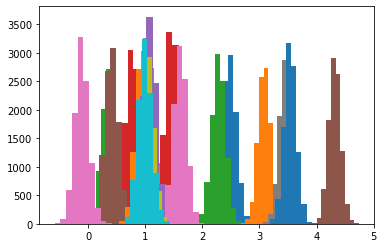

In [22]:
for i in range(20):
    plt.hist(mu_vals[:,0, i])

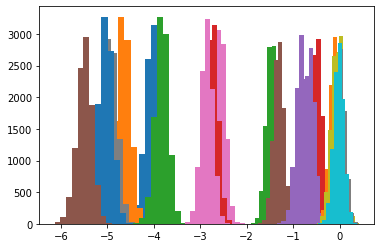

In [23]:
for i in range(20):
    plt.hist(log_vals[:,0, i])

In [83]:
n = 2
with torch.no_grad():
    for yh, y_a in zip(y_hat, y):
        print(f'{yh.detach().item()} | {y_a} | {(yh-y_a).pow(n)}')

    print()
    print((yh-y_a).pow(n).mean())

1.364013671875 | 0.4771212637424469 | tensor([[0.7866]], device='cuda:0')
1.3105111122131348 | 1.556302547454834 | tensor([[0.0604]], device='cuda:0')
1.7251465320587158 | 1.6720978021621704 | tensor([[0.0028]], device='cuda:0')
1.75349760055542 | 1.6127839088439941 | tensor([[0.0198]], device='cuda:0')
1.6532137393951416 | 1.4471579790115356 | tensor([[0.0425]], device='cuda:0')
1.3493053913116455 | 1.3617278337478638 | tensor([[0.0002]], device='cuda:0')
1.480534553527832 | 1.3424227237701416 | tensor([[0.0191]], device='cuda:0')
1.259460687637329 | 1.6434526443481445 | tensor([[0.1474]], device='cuda:0')
1.2042808532714844 | 1.6020599603652954 | tensor([[0.1582]], device='cuda:0')
1.8668303489685059 | 1.9493900537490845 | tensor([[0.0068]], device='cuda:0')
1.4541853666305542 | 2.2355284690856934 | tensor([[0.6105]], device='cuda:0')
1.4478633403778076 | 1.3424227237701416 | tensor([[0.0111]], device='cuda:0')
1.301031470298767 | 1.5440680980682373 | tensor([[0.0591]], device='cuda:

In [115]:
# Capture testing performance.
model.eval()
frobenius_norms = []
poisson = []
mean_squared_error = []
kl_divergence = []
avg_pnll = 0
avg_mse = 0
avg_kld = 0
with torch.no_grad():
    for batch_idx, (data, y) in enumerate(test_loader):
        # Add to GPU
        data = data.to(device)
        y = y.to(device)
        s, W, mu, logvar, y_hat = model(data)
        W = W.to(device)
        recon_batch = s @ W
        PNLL, MSE, KLD = model.loss_function(
            recon_batch, data, mu, logvar, y, y_hat
        )
        loss = torch.mean(MSE)#PNLL + MSE + 0.1 * KLD)
        avg_pnll += torch.mean(PNLL).item()
        avg_mse += torch.mean(MSE).item()
        avg_kld += torch.mean(KLD).item()
        epoch_test_loss += loss.item()

        # Calculate frobenius norm of the reconstructed matrix
        frobenius_norms.append(
            torch.norm(recon_batch - data, p="fro", dim=2).mean().item()
        )
        mean_squared_error.append(MSE)
        kl_divergence.append(KLD)

avg_mse /= len(test_loader.dataset)
avg_pnll /= len(test_loader.dataset)
avg_kld /= len(test_loader.dataset)
epoch_test_loss /= len(test_loader.dataset)

# # Append results to the json
# loss["val"]["pnll"].append(avg_pnll)
# loss["val"]["mse"].append(avg_mse)
# loss["val"]["kld"].append(avg_kld)
# loss["val"]["total"].append(epoch_test_loss)

avg_f_norm = sum(frobenius_norms) / len(frobenius_norms)
print("===> Test set loss: {:.4f}".format(epoch_test_loss))
# Print frobenius norm
print("======> Test set frobenius norm: {:.4f}".format(avg_f_norm))
print("======> Test set mean squared error: {:.4f}".format(avg_mse))
print("======> Test set kl divergence: {:.4f}".format(avg_kld))
print("======> Test set poisson: {:.4f}".format(avg_pnll))

===> Test set loss: 0.0004
======> Test set frobenius norm: 902.3006
======> Test set mean squared error: 0.0004
======> Test set kl divergence: 8.2761
======> Test set poisson: 0.0811


In [85]:
import matplotlib.pyplot as plt

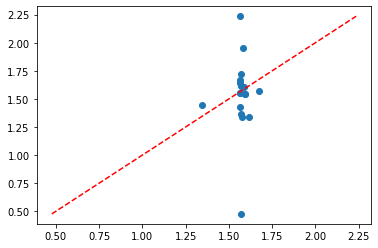

In [116]:
y_hat = y_hat.to('cpu').detach()
y = y.to('cpu').detach()
perfect = np.linspace(min(y), max(y), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.scatter(y_hat, y)

In [117]:
y_vals = []
y_preds = []
for x, y in test_loader:
    x = x.to(device)
    y_vals.append(y)
    s, W, mu, logvar, y_hat = model(x)
    y_preds.append(y_hat)


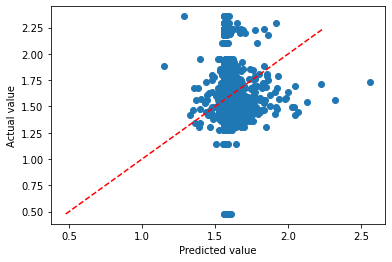

In [118]:
y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y), max(y), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)

# let's see if we can simply overfit a model...why can't we get this model to be good???

In [117]:
class overfit(nn.Module):
    """
    I'm creating this model to see if we can just overfit a model to
    predict the AQI on a given day using count vectors.
    """
    def __init__(self, vocab):
        super().__init__()
        self.fc1 = nn.Linear(vocab, 5000, bias=True)
        self.fc2 = nn.Linear(5000, 2000, bias=True)
        self.fc3 = nn.Linear(2000, 1000, bias=True)
        self.fc4 = nn.Linear(1000, 1)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        
        return h4
    
    def loss_function(self, y, y_hat):
        mse = (y-y_hat).pow(2).mean()
        return mse
    

In [118]:
model = overfit(tweets.vocab_size)
model.to(device)

EPOCHS = 100
print_rate = 10
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [119]:
for epoch in range(EPOCHS):
    epoch_train_loss = 0
    epoch_test_loss = 0
    # Run method on training
    model.train()
    avg_mse = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        # Add training data to GPU
        data = data.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(data)
        y_hat = y_hat.to(device)
        loss = model.loss_function(y, y_hat)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            avg_mse += torch.mean(MSE).item()
        epoch_train_loss += loss.item()

        if batch_idx % print_rate == 0:
            print(
                "Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    print(
        "===> Epoch: {} Average Loss: {:.4f}".format(
            epoch, epoch_train_loss / len(train_loader.dataset)
        )
    )
    print("MSE: ", avg_mse / batch_idx)

Train epoch: 0 [0/9800 (0%)]	Loss: 0.021266
Train epoch: 0 [1280/9800 (13%)]	Loss: 0.002524
Train epoch: 0 [2560/9800 (26%)]	Loss: 0.000430
Train epoch: 0 [3840/9800 (39%)]	Loss: 0.000483
Train epoch: 0 [5120/9800 (52%)]	Loss: 0.000404
Train epoch: 0 [6400/9800 (65%)]	Loss: 0.000336
Train epoch: 0 [7680/9800 (78%)]	Loss: 0.000333
Train epoch: 0 [8960/9800 (91%)]	Loss: 0.000407
===> Epoch: 0 Average Loss: 0.5964
MSE:  0.045076619735673853
Train epoch: 1 [0/9800 (0%)]	Loss: 0.000431
Train epoch: 1 [1280/9800 (13%)]	Loss: 0.000314
Train epoch: 1 [2560/9800 (26%)]	Loss: 0.000426
Train epoch: 1 [3840/9800 (39%)]	Loss: 0.000462
Train epoch: 1 [5120/9800 (52%)]	Loss: 0.000382
Train epoch: 1 [6400/9800 (65%)]	Loss: 0.000323
Train epoch: 1 [7680/9800 (78%)]	Loss: 0.000312
Train epoch: 1 [8960/9800 (91%)]	Loss: 0.000399
===> Epoch: 1 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 2 [0/9800 (0%)]	Loss: 0.000372
Train epoch: 2 [1280/9800 (13%)]	Loss: 0.000322
Train epoch: 2 [2560/980

Train epoch: 18 [5120/9800 (52%)]	Loss: 0.000422
Train epoch: 18 [6400/9800 (65%)]	Loss: 0.000450
Train epoch: 18 [7680/9800 (78%)]	Loss: 0.000342
Train epoch: 18 [8960/9800 (91%)]	Loss: 0.000682
===> Epoch: 18 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 19 [0/9800 (0%)]	Loss: 0.000460
Train epoch: 19 [1280/9800 (13%)]	Loss: 0.000298
Train epoch: 19 [2560/9800 (26%)]	Loss: 0.000423
Train epoch: 19 [3840/9800 (39%)]	Loss: 0.000463
Train epoch: 19 [5120/9800 (52%)]	Loss: 0.000463
Train epoch: 19 [6400/9800 (65%)]	Loss: 0.000304
Train epoch: 19 [7680/9800 (78%)]	Loss: 0.000314
Train epoch: 19 [8960/9800 (91%)]	Loss: 0.000385
===> Epoch: 19 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 20 [0/9800 (0%)]	Loss: 0.000378
Train epoch: 20 [1280/9800 (13%)]	Loss: 0.000296
Train epoch: 20 [2560/9800 (26%)]	Loss: 0.000425
Train epoch: 20 [3840/9800 (39%)]	Loss: 0.000440
Train epoch: 20 [5120/9800 (52%)]	Loss: 0.000372
Train epoch: 20 [6400/9800 (65%)]	Loss: 0.000297


Train epoch: 36 [7680/9800 (78%)]	Loss: 0.000312
Train epoch: 36 [8960/9800 (91%)]	Loss: 0.000381
===> Epoch: 36 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 37 [0/9800 (0%)]	Loss: 0.000352
Train epoch: 37 [1280/9800 (13%)]	Loss: 0.000291
Train epoch: 37 [2560/9800 (26%)]	Loss: 0.000382
Train epoch: 37 [3840/9800 (39%)]	Loss: 0.000436
Train epoch: 37 [5120/9800 (52%)]	Loss: 0.000370
Train epoch: 37 [6400/9800 (65%)]	Loss: 0.000337
Train epoch: 37 [7680/9800 (78%)]	Loss: 0.000317
Train epoch: 37 [8960/9800 (91%)]	Loss: 0.000389
===> Epoch: 37 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 38 [0/9800 (0%)]	Loss: 0.000350
Train epoch: 38 [1280/9800 (13%)]	Loss: 0.000291
Train epoch: 38 [2560/9800 (26%)]	Loss: 0.000382
Train epoch: 38 [3840/9800 (39%)]	Loss: 0.000437
Train epoch: 38 [5120/9800 (52%)]	Loss: 0.000362
Train epoch: 38 [6400/9800 (65%)]	Loss: 0.000322
Train epoch: 38 [7680/9800 (78%)]	Loss: 0.000314
Train epoch: 38 [8960/9800 (91%)]	Loss: 0.000399


===> Epoch: 54 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 55 [0/9800 (0%)]	Loss: 0.000350
Train epoch: 55 [1280/9800 (13%)]	Loss: 0.000307
Train epoch: 55 [2560/9800 (26%)]	Loss: 0.000389
Train epoch: 55 [3840/9800 (39%)]	Loss: 0.000463
Train epoch: 55 [5120/9800 (52%)]	Loss: 0.000370
Train epoch: 55 [6400/9800 (65%)]	Loss: 0.000302
Train epoch: 55 [7680/9800 (78%)]	Loss: 0.000305
Train epoch: 55 [8960/9800 (91%)]	Loss: 0.000377
===> Epoch: 55 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 56 [0/9800 (0%)]	Loss: 0.000350
Train epoch: 56 [1280/9800 (13%)]	Loss: 0.000301
Train epoch: 56 [2560/9800 (26%)]	Loss: 0.000386
Train epoch: 56 [3840/9800 (39%)]	Loss: 0.000460
Train epoch: 56 [5120/9800 (52%)]	Loss: 0.000366
Train epoch: 56 [6400/9800 (65%)]	Loss: 0.000301
Train epoch: 56 [7680/9800 (78%)]	Loss: 0.000300
Train epoch: 56 [8960/9800 (91%)]	Loss: 0.000377
===> Epoch: 56 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 57 [0/9800 (0%)]	Loss:

KeyboardInterrupt: 

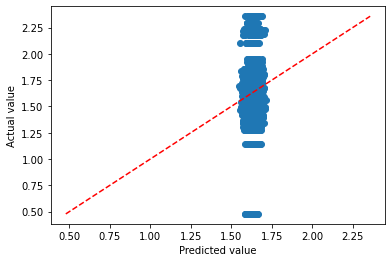

In [116]:
y_vals = []
y_preds = []
for x, y in train_loader:
    x = x.to(device)
    y_vals.append(y)
    y_hat = model(x)
    y_preds.append(y_hat)

y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y_vals), max(y_vals), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)

In [50]:
df = tweets.x

In [78]:
x_train_new = []
y_train_new = []
for x, y in train_loader:
    x_train_new.append(x.detach().cpu().numpy().reshape(-1, 7244))
    y_train_new.append(y.detach().cpu().numpy().reshape(-1,1))

In [87]:
x_train_new = np.concatenate(x_train_new)
y_train_new = np.concatenate(y_train_new)

In [88]:
from sklearn.neighbors import KNeighborsRegressor

In [89]:
model = KNeighborsRegressor(n_neighbors=5).fit(x_train_new, y_train_new)

In [91]:
y_pred = model.predict(x_train_new)

In [92]:
model.score(x_train_new, y_train_new)

0.9999999999999606

In [93]:
x_test_new = []
y_test_new = []
for x, y in test_loader:
    x_test_new.append(x.detach().cpu().numpy().reshape(-1, 7244))
    y_test_new.append(y.detach().cpu().numpy().reshape(-1,1))

In [96]:
x_test_new = np.concatenate(x_test_new)
y_test_new = np.concatenate(y_test_new)

In [97]:
model.score(x_test_new, y_test_new)

0.7806294117597303

In [99]:
y_preds = model.predict(x_test_new)

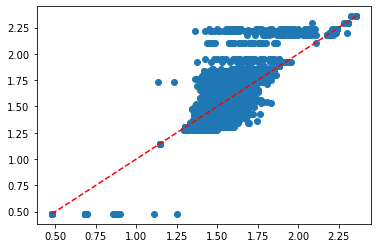

In [100]:
perfect = np.linspace(min(y_test_new), max(y_test_new), 100)
plt.scatter(y_preds, y_test_new)

plt.plot(perfect, perfect, '--', color='red')
plt.show()


In [56]:
tweets.x

array([[datetime.date(2018, 5, 28),
        <1x7252 sparse matrix of type '<class 'numpy.int64'>'
        	with 6 stored elements in Compressed Sparse Row format>],
       [datetime.date(2018, 5, 16),
        <1x7252 sparse matrix of type '<class 'numpy.int64'>'
        	with 1 stored elements in Compressed Sparse Row format>],
       [datetime.date(2018, 7, 18),
        <1x7252 sparse matrix of type '<class 'numpy.int64'>'
        	with 2 stored elements in Compressed Sparse Row format>],
       ...,
       [datetime.date(2018, 8, 18),
        <1x7252 sparse matrix of type '<class 'numpy.int64'>'
        	with 0 stored elements in Compressed Sparse Row format>],
       [datetime.date(2018, 10, 11),
        <1x7252 sparse matrix of type '<class 'numpy.int64'>'
        	with 7 stored elements in Compressed Sparse Row format>],
       [datetime.date(2018, 6, 8),
        <1x7252 sparse matrix of type '<class 'numpy.int64'>'
        	with 2 stored elements in Compressed Sparse Row format>]